# How to get started with Numerai

## *The hardest data science tournament on the planet?*

![](https://miro.medium.com/max/4000/1*g5PtFpII33P5EeHxFZN9YA.png)

![](https://camo.githubusercontent.com/55d9a214447683aae34c1c84b29fc401201d751b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67)

This notebook accompanies the [Weights and Biases Gallery Report](https://app.wandb.ai/gallery) on getting started with [Numerai](https://numer.ai). We will go through the whole process from loading the data to submitting your predictions to Numerai. [Weights and Biases](https://www.wandb.com/) will be used for experiment tracking and hyperparameter optimization.

## Preparation

In [1]:
# Install Numerai's API
!pip install numerapi
# Get the latest version of Weights and Biases
!pip install wandb --upgrade

     |████████████████████████████████| 1.8 MB 1.2 MB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.10
    Uninstalling wandb-0.10.10:
      Successfully uninstalled wandb-0.10.10


Weights and Biases requires you to add your WandB API key for logging in automatically. Because this is a secret key we will use [Kaggle User Secrets](https://www.kaggle.com/product-feedback/114053) to obfuscate the API key.

In [2]:
# Obfuscated WANDB API Key
from kaggle_secrets import UserSecretsClient
WANDB_KEY = UserSecretsClient().get_secret("WANDB_API_KEY")

In [3]:
import os
import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error

# Initialize Numerai's API
import numerapi
NAPI = numerapi.NumerAPI(verbosity="info")

# Weights and Biases
import wandb
from wandb.lightgbm import wandb_callback
wandb.login(key=WANDB_KEY)

# Data directory
DIR = "/kaggle/working"

# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Surpress Pandas warnings
pd.set_option('chained_assignment', None)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data Processing

In [4]:
def download_current_data(directory: str):
    """
    Downloads the data for the current round
    :param directory: The path to the directory where the data needs to be saved
    """
    current_round = NAPI.get_current_round()
    if os.path.isdir(f'{directory}/numerai_dataset_{current_round}/'):
        print(f"You already have the newest data! Current round is: {current_round}")
    else:
        print(f"Downloading new data for round: {current_round}!")
        NAPI.download_current_dataset(dest_path=directory, unzip=True)

def load_data(directory: str, reduce_memory: bool=True) -> tuple:
    """
    Get data for current round
    :param directory: The path to the directory where the data needs to be saved
    :return: A tuple containing the datasets
    """
    print('Loading the data')
    full_path = f'{directory}/numerai_dataset_{NAPI.get_current_round()}/'
    train_path = full_path + 'numerai_training_data.csv'
    test_path = full_path + 'numerai_tournament_data.csv'
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # Reduce all features to 32-bit floats
    if reduce_memory:
        num_features = [f for f in train.columns if f.startswith("feature")]
        train[num_features] = train[num_features].astype(np.float32)
        test[num_features] = test[num_features].astype(np.float32)
        
    val = test[test['data_type'] == 'validation']
    return train, val, test

In [5]:
# Download, unzip and load data
download_current_data(DIR)
train, val, test = load_data(DIR, reduce_memory=True)

/kaggle/working/numerai_dataset_238.zip: 379MB [00:29, 35.4MB/s]                           

Loading the data


## Exploratory Data Analysis (EDA)

The Numerai data has 310 obfuscated numerical features that can hold values of 0.0, 0.25, 0.5, 0.75, 1.00. The features are divided into 6 groups ("intelligence", "wisdom", "charisma", "dexterity", "strength" and "constitution"). The meaning of the groups is unclear, but we can use the fact that features are within the same group.

In [6]:
print("Training data:")
display(train.head(2))
print("Test data:")
display(test.head(2))

Training data:


id   era data_type  feature_intelligence1  \
0  n000315175b67977  era1     train                    0.0   
1  n0014af834a96cdd  era1     train                    0.0   

   feature_intelligence2  feature_intelligence3  feature_intelligence4  \
0                    0.5                   0.25                   0.00   
1                    0.0                   0.00                   0.25   

   feature_intelligence5  feature_intelligence6  feature_intelligence7  ...  \
0                    0.5                   0.25                   0.25  ...   
1                    0.5                   0.00                   0.00  ...   

   feature_wisdom38  feature_wisdom39  feature_wisdom40  feature_wisdom41  \
0               1.0               1.0              0.75               0.5   
1               1.0               1.0              0.00               0.0   

   feature_wisdom42  feature_wisdom43  feature_wisdom44  feature_wisdom45  \
0              0.75              0.50               1.0              0.50   
1              0.75              0.25               0.0              0.25   

   feature_wisdom46  target  
0              0.75    0.50  
1              1.00    0.25  

[2 rows x 314 columns]

Test data:


id     era   data_type  feature_intelligence1  \
0  n0003aa52cab36c2  era121  validation                   0.25   
1  n000920ed083903f  era121  validation                   0.75   

   feature_intelligence2  feature_intelligence3  feature_intelligence4  \
0                   0.75                   0.50                    0.5   
1                   0.50                   0.75                    1.0   

   feature_intelligence5  feature_intelligence6  feature_intelligence7  ...  \
0                    0.0                   0.75                    0.5  ...   
1                    0.5                   0.00                    0.0  ...   

   feature_wisdom38  feature_wisdom39  feature_wisdom40  feature_wisdom41  \
0              0.75              0.75              1.00              0.75   
1              0.50              0.50              0.75              1.00   

   feature_wisdom42  feature_wisdom43  feature_wisdom44  feature_wisdom45  \
0              0.50               0.5               1.0               0.0   
1              0.75               0.5               0.5               0.5   

   feature_wisdom46  target  
0               0.0    0.25  
1               0.5    0.50  

[2 rows x 314 columns]

In [7]:
print("Training set info:")
train.info()

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 608.7+ MB


In [8]:
print("Test set info:")
test.info()

Test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581162 entries, 0 to 1581161
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 1.9+ GB


When we group by the eras it can be seen that the era sizes change over time. This can be taken into account when creating features using the eras.

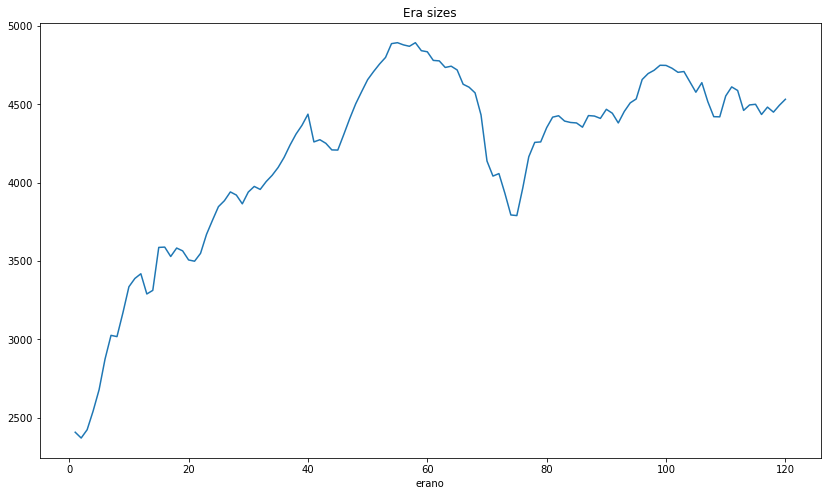

In [9]:
# Extract era numbers
train["erano"] = train.era.str.slice(3).astype(int)
plt.figure(figsize=[14, 6])
train.groupby(train['erano'])["target"].size().plot(title="Era sizes", figsize=(14, 8));

Most of the features have similar standard deviations, but some have very low variability. Consider standardizing the features or removing these low variability features when experimenting with for example neural networks.

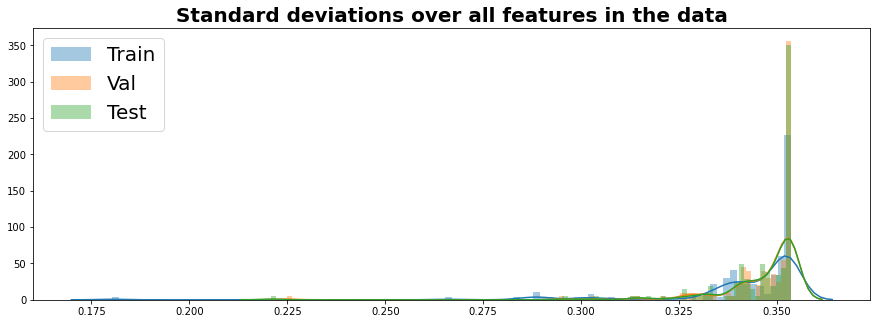

In [10]:
feats = [f for f in train.columns if "feature" in f]
plt.figure(figsize=(15, 5))
sns.distplot(pd.DataFrame(train[feats].std()), bins=100)
sns.distplot(pd.DataFrame(val[feats].std()), bins=100)
sns.distplot(pd.DataFrame(test[feats].std()), bins=100)
plt.legend(["Train", "Val", "Test"], fontsize=20)
plt.title("Standard deviations over all features in the data", weight='bold', fontsize=20);

## Metrics

In this experiment we will monitor the Spearman correlation (main metric), the Sharpe ratio, payout and Mean Absolute Error (MAE).

In [11]:
def sharpe_ratio(corrs: pd.Series) -> np.float32:
    """
    Calculate the Sharpe ratio for Numerai by using grouped per-era data
    
    :param corrs: A Pandas Series containing the Spearman correlations for each era
    :return: A float denoting the Sharpe ratio of your predictions.
    """
    return corrs.mean() / corrs.std()


def evaluate(df: pd.DataFrame) -> tuple:
    """
    Evaluate and display relevant metrics for Numerai 
    
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: A tuple of float containing the metrics
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """Calculates Spearman correlation"""
        return spearmanr(sub_df["target"], sub_df["prediction"])[0]
    
    # Calculate metrics
    corrs = df.groupby("era").apply(_score)
    payout_raw = (corrs / 0.2).clip(-1, 1)
    spearman = round(corrs.mean(), 4)
    payout = round(payout_raw.mean(), 4)
    numerai_sharpe = round(sharpe_ratio(corrs), 4)
    mae = mean_absolute_error(df["target"], df["prediction"]).round(4)

    # Display metrics
    print(f"Spearman Correlation: {spearman}")
    print(f"Average Payout: {payout}")
    print(f"Sharpe Ratio: {numerai_sharpe}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return spearman, payout, numerai_sharpe, mae

## Feature Engineering

The features have a remarkably low correlation to the target variable. Even the most correlated features only have around 1.5% correlation with the target. Engineering useful features out of feature + era groups is key for creating good Numerai models.

Additionally, the importance of features may change over time and by selecting a limited number of features we risk having a high "feature exposure". Feature exposure can be quantified as the standard deviation of all your predictions' correlations  with each feature. You can mitigate this risk by using dimensionality reduction techniques like Principal Component Analysis (PCA) to integrate almost all features into your model.

One example of creating features out of the groups is to calculate statistical moments (mean, standard deviation, skewness) of every group. 

In [12]:
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create features by calculating statistical moments for each group.
    
    :param df: Pandas DataFrame containing all features
    """
    for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
        cols = [col for col in df.columns if group in col]
        df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
        df[f"feature_{group}_std"] = df[cols].std(axis=1)
        df[f"feature_{group}_skew"] = df[cols].skew(axis=1)
    return df

In [13]:
# Add group statistics features
train = get_group_stats(train)
val = get_group_stats(val)
test = get_group_stats(test)

## Feature Selection

The features have a remarkably low correlation to the target variable. Even the most correlated features only have around 1.5% correlation with the target. Engineering useful features out of feature and era groupings is key for creating good Numerai models.

Also, the importance of features may change over time. By selecting a limited number of features we risk having a high "feature exposure". Feature exposure can be quantified as the standard deviation of all your predictions' correlations  with each feature. You can mitigate this risk by using dimensionality reduction techniques like Principal Component Analysis (PCA) to integrate almost all features into your model. In this starter example we take the 150 features that are most correlated to the target variable.

In [14]:
# Calculate correlations with target
full_corr = train.corr()
corr_with_target = full_corr["target"].T.apply(abs).sort_values(ascending=False)

# Select features with highest correlation to the target variable
features = corr_with_target[:150]
features.drop("target", inplace=True)

In [15]:
print("Top 10 Features according to correlation with target:")
features[:10]

Top 10 Features according to correlation with target:


feature_charisma_mean    0.013717
feature_charisma_skew    0.013131
feature_strength34       0.012310
feature_dexterity7       0.012175
feature_dexterity6       0.011807
feature_dexterity4       0.011706
feature_strength14       0.011353
feature_charisma69       0.010858
feature_dexterity11      0.010820
feature_charisma37       0.010719
Name: target, dtype: float64

In [16]:
# Create list of most correlated features
feature_list = features.index.tolist()

## Modeling (using Weights and Biases)

To get a first good model for Numerai we will train a [LightGBM](https://lightgbm.readthedocs.io/en/latest) model and use Weights and Biases to do a hyperparameter sweep. In this example it will be a grid search over some of the most important hyperparameters for LightGBM. First, we define the configuration of the sweep.

In [17]:
# Configuration for hyperparameter sweep
sweep_config = {
   'method': 'grid',
   'metric': {
          'name': 'mse',
          'goal': 'minimize'   
        },
   'parameters': {
       "num_leaves": {'values': [30, 40, 50]}, 
       "max_depth": {'values': [4, 5, 6, 7]}, 
       "learning_rate": {'values': [0.1, 0.05, 0.01]},
       "bagging_freq": {'values': [7]}, 
       "bagging_fraction": {'values': [0.6, 0.7, 0.8]}, 
       "feature_fraction": {'values': [0.85, 0.75, 0.65]},
   }
}
sweep_id = wandb.sweep(sweep_config, project="numerai_tutorial")

Create sweep with ID: vky9k38m
Sweep URL: https://wandb.ai/carlolepelaars/numerai_tutorial/sweeps/vky9k38m


After that we define a function (_train) using wandb.config attributes so Weights and Biases can perform the grid search. We then log all the results and start the agent.

In [18]:
# Prepare data for LightGBM
dtrain = lgb.Dataset(train[feature_list], label=train["target"])
dvalid = lgb.Dataset(val[feature_list], label=val["target"])
watchlist = [dtrain, dvalid]

def _train():
    # Configure and train model
    wandb.init(name="LightGBM_sweep")
    lgbm_config = {"num_leaves": wandb.config.num_leaves, "max_depth": wandb.config.max_depth, "learning_rate": wandb.config.learning_rate,
                   "bagging_freq": wandb.config.bagging_freq, "bagging_fraction": wandb.config.bagging_fraction, "feature_fraction": wandb.config.feature_fraction,
                   "metric": 'mse', "random_state": seed}
    lgbm_model = lgb.train(lgbm_config, train_set=dtrain, num_boost_round=750, valid_sets=watchlist, 
                           callbacks=[wandb_callback()], verbose_eval=100, early_stopping_rounds=50)
    
    # Create predictions for evaluation
    val_preds = lgbm_model.predict(val[feature_list], num_iteration=lgbm_model.best_iteration)
    val.loc[:, "prediction"] = val_preds
    # W&B log metrics
    spearman, payout, numerai_sharpe, mae = evaluate(val)
    wandb.log({"Spearman": spearman, "Payout": payout, "Numerai Sharpe Ratio": numerai_sharpe, "Mean Absolute Error": mae})
    
# Run hyperparameter sweep (grid search)
wandb.agent(sweep_id, function=_train)

wandb: Agent Starting Run: zwwt6hvb with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
wandb: Currently logged in as: carlolepelaars (use `wandb login --relogin` to force relogin)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0497158	valid_1's l2: 0.0499349
Spearman Correlation: 0.0168
Average Payout: 0.0842
Sharpe Ratio: 0.5482
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: dzfxga43 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0497158	valid_1's l2: 0.0499349
Spearman Correlation: 0.0168
Average Payout: 0.0842
Sharpe Ratio: 0.5482
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: nhm4jwhi with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0497158	valid_1's l2: 0.0499349
Spearman Correlation: 0.0168
Average Payout: 0.0842
Sharpe Ratio: 0.5482
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: fo4kvlip with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497323	valid_1's l2: 0.0499353
Spearman Correlation: 0.0167
Average Payout: 0.0836
Sharpe Ratio: 0.5727
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: 6mbcntn1 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497302	valid_1's l2: 0.049935
Spearman Correlation: 0.017
Average Payout: 0.0851
Sharpe Ratio: 0.5817
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: 6ckkbngn with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497302	valid_1's l2: 0.049935
Spearman Correlation: 0.017
Average Payout: 0.0851
Sharpe Ratio: 0.5817
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: w9q1fucw with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's l2: 0.0497072	valid_1's l2: 0.0499318
Spearman Correlation: 0.0161
Average Payout: 0.0804
Sharpe Ratio: 0.5283
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 6y7kz5ls with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's l2: 0.0497408	valid_1's l2: 0.0499368
Spearman Correlation: 0.013
Average Payout: 0.0651
Sharpe Ratio: 0.4536
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: dcneehpp with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0496807	valid_1's l2: 0.0499299
Spearman Correlation: 0.0156
Average Payout: 0.078
Sharpe Ratio: 0.5466
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 1of1jn35 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.0497337	valid_1's l2: 0.0499364
Spearman Correlation: 0.0132
Average Payout: 0.0658
Sharpe Ratio: 0.4533
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: ntil3d2n with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496597	valid_1's l2: 0.0499386
Spearman Correlation: 0.0143
Average Payout: 0.0715
Sharpe Ratio: 0.5091
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: hzvnml96 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.049688	valid_1's l2: 0.0499361
Spearman Correlation: 0.0145
Average Payout: 0.0726
Sharpe Ratio: 0.4819
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: ok9mrwhz with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496074	valid_1's l2: 0.0499393
Early stopping, best iteration is:
[51]	training's l2: 0.0496905	valid_1's l2: 0.049928
Spearman Correlation: 0.0194
Average Payout: 0.0972
Sharpe Ratio: 0.5823
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 98lfrl1o with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496074	valid_1's l2: 0.0499393
Early stopping, best iteration is:
[51]	training's l2: 0.0496905	valid_1's l2: 0.049928
Spearman Correlation: 0.0194
Average Payout: 0.0972
Sharpe Ratio: 0.5823
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: a4bi2b7i with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496074	valid_1's l2: 0.0499393
Early stopping, best iteration is:
[51]	training's l2: 0.0496905	valid_1's l2: 0.049928
Spearman Correlation: 0.0194
Average Payout: 0.0972
Sharpe Ratio: 0.5823
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: bb2fe3uk with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0496232	valid_1's l2: 0.0499272
Spearman Correlation: 0.0201
Average Payout: 0.1004
Sharpe Ratio: 0.6045
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: mfp5nb3f with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0494511	valid_1's l2: 0.0499401
Early stopping, best iteration is:
[55]	training's l2: 0.04958	valid_1's l2: 0.0499272
Spearman Correlation: 0.0211
Average Payout: 0.1055
Sharpe Ratio: 0.635
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: v41gauom with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0494511	valid_1's l2: 0.0499401
Early stopping, best iteration is:
[55]	training's l2: 0.04958	valid_1's l2: 0.0499272
Spearman Correlation: 0.0211
Average Payout: 0.1055
Sharpe Ratio: 0.635
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: i0umkzxe with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's l2: 0.0497017	valid_1's l2: 0.0499319
Spearman Correlation: 0.0168
Average Payout: 0.0839
Sharpe Ratio: 0.5915
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: xd2enb4q with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.0496843	valid_1's l2: 0.0499286
Spearman Correlation: 0.0184
Average Payout: 0.0921
Sharpe Ratio: 0.6374
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: t5ds2zlt with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497202	valid_1's l2: 0.0499309
Spearman Correlation: 0.0179
Average Payout: 0.0894
Sharpe Ratio: 0.6313
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: rppwi51w with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.049649	valid_1's l2: 0.0499295
Spearman Correlation: 0.0186
Average Payout: 0.093
Sharpe Ratio: 0.6247
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 3lsvblnu with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's l2: 0.049531	valid_1's l2: 0.0499327
Spearman Correlation: 0.0188
Average Payout: 0.0939
Sharpe Ratio: 0.5973
Mean Absolute Error (MAE): 0.1524


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ch9cu1g2 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0496965	valid_1's l2: 0.0499296
Spearman Correlation: 0.0183
Average Payout: 0.0913
Sharpe Ratio: 0.6222
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: 9j4mj2o3 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497661	valid_1's l2: 0.0499336
[200]	training's l2: 0.0497108	valid_1's l2: 0.0499295
Early stopping, best iteration is:
[178]	training's l2: 0.0497216	valid_1's l2: 0.0499281
Spearman Correlation: 0.0188
Average Payout: 0.0939
Sharpe Ratio: 0.5768
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: mr6f06gy with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497661	valid_1's l2: 0.0499336
[200]	training's l2: 0.0497108	valid_1's l2: 0.0499295
Early stopping, best iteration is:
[178]	training's l2: 0.0497216	valid_1's l2: 0.0499281
Spearman Correlation: 0.0188
Average Payout: 0.0939
Sharpe Ratio: 0.5768
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: bt9qiv7l with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497661	valid_1's l2: 0.0499336
[200]	training's l2: 0.0497108	valid_1's l2: 0.0499295
Early stopping, best iteration is:
[178]	training's l2: 0.0497216	valid_1's l2: 0.0499281
Spearman Correlation: 0.0188
Average Payout: 0.0939
Sharpe Ratio: 0.5768
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 9cx6ixc4 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497262	valid_1's l2: 0.0499315
[200]	training's l2: 0.0496385	valid_1's l2: 0.0499275
Early stopping, best iteration is:
[168]	training's l2: 0.0496636	valid_1's l2: 0.0499258
Spearman Correlation: 0.0198
Average Payout: 0.0989
Sharpe Ratio: 0.6219
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: h2yulogi with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497234	valid_1's l2: 0.0499312
Early stopping, best iteration is:
[147]	training's l2: 0.0496781	valid_1's l2: 0.0499253
Spearman Correlation: 0.0197
Average Payout: 0.0985
Sharpe Ratio: 0.6212
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: yekwb53o with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497234	valid_1's l2: 0.0499312
Early stopping, best iteration is:
[147]	training's l2: 0.0496781	valid_1's l2: 0.0499253
Spearman Correlation: 0.0197
Average Payout: 0.0985
Sharpe Ratio: 0.6212
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 8dpblh72 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497186	valid_1's l2: 0.0499305
Early stopping, best iteration is:
[147]	training's l2: 0.0496709	valid_1's l2: 0.0499266
Spearman Correlation: 0.0193
Average Payout: 0.0966
Sharpe Ratio: 0.5989
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 2uxvg79p with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496932	valid_1's l2: 0.0499285
Early stopping, best iteration is:
[147]	training's l2: 0.0496347	valid_1's l2: 0.0499258
Spearman Correlation: 0.0202
Average Payout: 0.101
Sharpe Ratio: 0.6327
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: a68my5ou with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496707	valid_1's l2: 0.0499285
Early stopping, best iteration is:
[144]	training's l2: 0.0496074	valid_1's l2: 0.0499255
Spearman Correlation: 0.0202
Average Payout: 0.1011
Sharpe Ratio: 0.6383
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: 5zvp6wh9 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497156	valid_1's l2: 0.0499296
[200]	training's l2: 0.0496177	valid_1's l2: 0.0499254
Early stopping, best iteration is:
[181]	training's l2: 0.0496341	valid_1's l2: 0.0499244
Spearman Correlation: 0.0202
Average Payout: 0.1008
Sharpe Ratio: 0.6293
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 0086e7of with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496879	valid_1's l2: 0.04993
[200]	training's l2: 0.0495659	valid_1's l2: 0.0499282
Early stopping, best iteration is:
[162]	training's l2: 0.0496086	valid_1's l2: 0.0499263
Spearman Correlation: 0.0198
Average Payout: 0.0992
Sharpe Ratio: 0.6294
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 1oeza1o9 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496622	valid_1's l2: 0.0499273
Early stopping, best iteration is:
[142]	training's l2: 0.0495979	valid_1's l2: 0.0499234
Spearman Correlation: 0.0204
Average Payout: 0.1019
Sharpe Ratio: 0.6519
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: dp1icw0h with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0497173	valid_1's l2: 0.0499352
Spearman Correlation: 0.017
Average Payout: 0.0852
Sharpe Ratio: 0.5782
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: rmcoejfs with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0497173	valid_1's l2: 0.0499352
Spearman Correlation: 0.017
Average Payout: 0.0852
Sharpe Ratio: 0.5782
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 9u5khgzl with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0497173	valid_1's l2: 0.0499352
Spearman Correlation: 0.017
Average Payout: 0.0852
Sharpe Ratio: 0.5782
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: jruv0zrh with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's l2: 0.0496588	valid_1's l2: 0.0499367
Spearman Correlation: 0.0168
Average Payout: 0.0841
Sharpe Ratio: 0.591
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 5zhbrmpy with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497307	valid_1's l2: 0.0499382
Spearman Correlation: 0.0135
Average Payout: 0.0674
Sharpe Ratio: 0.5026
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: cwzttdu1 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497307	valid_1's l2: 0.0499382
Spearman Correlation: 0.0135
Average Payout: 0.0674
Sharpe Ratio: 0.5026
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: 6zy7me2p with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.049717	valid_1's l2: 0.0499359
Spearman Correlation: 0.0157
Average Payout: 0.0784
Sharpe Ratio: 0.5078
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: eggo0jma with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497047	valid_1's l2: 0.0499357
Spearman Correlation: 0.0163
Average Payout: 0.0815
Sharpe Ratio: 0.5238
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: z7t7v94d with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0496814	valid_1's l2: 0.0499352
Spearman Correlation: 0.0153
Average Payout: 0.0767
Sharpe Ratio: 0.5264
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: ldjx63jt with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0497229	valid_1's l2: 0.0499336
Spearman Correlation: 0.0168
Average Payout: 0.0838
Sharpe Ratio: 0.5739
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: q4x44q13 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.0496865	valid_1's l2: 0.0499387
Spearman Correlation: 0.0155
Average Payout: 0.0776
Sharpe Ratio: 0.4873
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: cw7fom7h with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497384	valid_1's l2: 0.0499382
Spearman Correlation: 0.0139
Average Payout: 0.0695
Sharpe Ratio: 0.4561
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: uszxg9ix with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0497094	valid_1's l2: 0.0499318
Spearman Correlation: 0.0173
Average Payout: 0.0867
Sharpe Ratio: 0.5056
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 89ycu10h with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0497094	valid_1's l2: 0.0499318
Spearman Correlation: 0.0173
Average Payout: 0.0867
Sharpe Ratio: 0.5056
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: wzt9d0c9 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0497094	valid_1's l2: 0.0499318
Spearman Correlation: 0.0173
Average Payout: 0.0867
Sharpe Ratio: 0.5056
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 1eedchcj with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's l2: 0.0496808	valid_1's l2: 0.0499324
Spearman Correlation: 0.0177
Average Payout: 0.0884
Sharpe Ratio: 0.5406
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: rf4ccyvf with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's l2: 0.049637	valid_1's l2: 0.0499329
Spearman Correlation: 0.0175
Average Payout: 0.0875
Sharpe Ratio: 0.5537
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: xc5zdz7a with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's l2: 0.049637	valid_1's l2: 0.0499329
Spearman Correlation: 0.0175
Average Payout: 0.0875
Sharpe Ratio: 0.5537
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: c3wbs4wu with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.049609	valid_1's l2: 0.0499338
Spearman Correlation: 0.0184
Average Payout: 0.0921
Sharpe Ratio: 0.5757
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: i6h0y4af with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.049691	valid_1's l2: 0.0499323
Spearman Correlation: 0.0166
Average Payout: 0.0828
Sharpe Ratio: 0.5422
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: 3wwrhbjr with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0496653	valid_1's l2: 0.0499298
Spearman Correlation: 0.0189
Average Payout: 0.0943
Sharpe Ratio: 0.6213
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: r3lgovbr with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's l2: 0.0496172	valid_1's l2: 0.0499363
Spearman Correlation: 0.0179
Average Payout: 0.0893
Sharpe Ratio: 0.5434
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 5ytoz1lu with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	training's l2: 0.0496874	valid_1's l2: 0.0499343
Spearman Correlation: 0.0154
Average Payout: 0.0772
Sharpe Ratio: 0.5105
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: sxc4x0s2 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's l2: 0.0495192	valid_1's l2: 0.0499347
Spearman Correlation: 0.0196
Average Payout: 0.0978
Sharpe Ratio: 0.6377
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: jjixo35u with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497664	valid_1's l2: 0.0499325
[200]	training's l2: 0.0497117	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[177]	training's l2: 0.049723	valid_1's l2: 0.0499267
Spearman Correlation: 0.0192
Average Payout: 0.096
Sharpe Ratio: 0.5903
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: yx6cqi45 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497664	valid_1's l2: 0.0499325
[200]	training's l2: 0.0497117	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[177]	training's l2: 0.049723	valid_1's l2: 0.0499267
Spearman Correlation: 0.0192
Average Payout: 0.096
Sharpe Ratio: 0.5903
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: lakernfq with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497664	valid_1's l2: 0.0499325
[200]	training's l2: 0.0497117	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[177]	training's l2: 0.049723	valid_1's l2: 0.0499267
Spearman Correlation: 0.0192
Average Payout: 0.096
Sharpe Ratio: 0.5903
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: l3orn3ev with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497262	valid_1's l2: 0.0499315
[200]	training's l2: 0.049639	valid_1's l2: 0.049927
Early stopping, best iteration is:
[170]	training's l2: 0.0496624	valid_1's l2: 0.0499258
Spearman Correlation: 0.0193
Average Payout: 0.0965
Sharpe Ratio: 0.6
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: tfeeoqb1 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497234	valid_1's l2: 0.0499311
[200]	training's l2: 0.0496343	valid_1's l2: 0.0499276
Early stopping, best iteration is:
[176]	training's l2: 0.0496535	valid_1's l2: 0.0499259
Spearman Correlation: 0.0195
Average Payout: 0.0973
Sharpe Ratio: 0.6018
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: ug72a4x7 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497234	valid_1's l2: 0.0499311
[200]	training's l2: 0.0496343	valid_1's l2: 0.0499276
Early stopping, best iteration is:
[176]	training's l2: 0.0496535	valid_1's l2: 0.0499259
Spearman Correlation: 0.0195
Average Payout: 0.0973
Sharpe Ratio: 0.6018
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: ct5mk7te with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.049719	valid_1's l2: 0.0499306
[200]	training's l2: 0.0496253	valid_1's l2: 0.0499275
Early stopping, best iteration is:
[160]	training's l2: 0.0496599	valid_1's l2: 0.0499262
Spearman Correlation: 0.0197
Average Payout: 0.0983
Sharpe Ratio: 0.6098
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: vx4v6i3l with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496937	valid_1's l2: 0.0499285
Early stopping, best iteration is:
[147]	training's l2: 0.0496361	valid_1's l2: 0.0499247
Spearman Correlation: 0.0202
Average Payout: 0.1011
Sharpe Ratio: 0.6255
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: gslbokpe with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496712	valid_1's l2: 0.0499292
Early stopping, best iteration is:
[144]	training's l2: 0.0496085	valid_1's l2: 0.0499251
Spearman Correlation: 0.0203
Average Payout: 0.1014
Sharpe Ratio: 0.6343
Mean Absolute Error (MAE): 0.1518


wandb: Sweep Agent: Waiting for job.
Error communicating with W&B: context deadline exceeded
Error communicating with W&B: context deadline exceeded
wandb: Job received.
wandb: Agent Starting Run: gmjmtrtv with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496628	valid_1's l2: 0.0499293
Early stopping, best iteration is:
[148]	training's l2: 0.049591	valid_1's l2: 0.0499244
Spearman Correlation: 0.0204
Average Payout: 0.1018
Sharpe Ratio: 0.622
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: 40akfgrt with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497448	valid_1's l2: 0.0499374
Spearman Correlation: 0.0156
Average Payout: 0.0779
Sharpe Ratio: 0.5146
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: c6wj786w with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497448	valid_1's l2: 0.0499374
Spearman Correlation: 0.0156
Average Payout: 0.0779
Sharpe Ratio: 0.5146
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: dglhhlbd with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497448	valid_1's l2: 0.0499374
Spearman Correlation: 0.0156
Average Payout: 0.0779
Sharpe Ratio: 0.5146
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: lqjb78ia with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0496848	valid_1's l2: 0.0499368
Spearman Correlation: 0.0164
Average Payout: 0.0822
Sharpe Ratio: 0.5498
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: pelmax95 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's l2: 0.0497957	valid_1's l2: 0.0499395
Spearman Correlation: 0.0136
Average Payout: 0.068
Sharpe Ratio: 0.5277
Mean Absolute Error (MAE): 0.1508


wandb: Agent Starting Run: h122p9g3 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's l2: 0.0497957	valid_1's l2: 0.0499395
Spearman Correlation: 0.0136
Average Payout: 0.068
Sharpe Ratio: 0.5277
Mean Absolute Error (MAE): 0.1508


wandb: Agent Starting Run: xyrtez27 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497709	valid_1's l2: 0.0499377
Spearman Correlation: 0.0136
Average Payout: 0.0681
Sharpe Ratio: 0.4655
Mean Absolute Error (MAE): 0.151


wandb: Agent Starting Run: aopo01sa with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497558	valid_1's l2: 0.0499329
Spearman Correlation: 0.0166
Average Payout: 0.0829
Sharpe Ratio: 0.596
Mean Absolute Error (MAE): 0.1511


wandb: Agent Starting Run: dt2nt68y with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497431	valid_1's l2: 0.0499327
Spearman Correlation: 0.0165
Average Payout: 0.0823
Sharpe Ratio: 0.6241
Mean Absolute Error (MAE): 0.1511


wandb: Agent Starting Run: zlq36gl5 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497714	valid_1's l2: 0.0499401
Spearman Correlation: 0.0132
Average Payout: 0.0659
Sharpe Ratio: 0.439
Mean Absolute Error (MAE): 0.151


wandb: Agent Starting Run: dh6wj3gb with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497536	valid_1's l2: 0.0499396
Spearman Correlation: 0.0134
Average Payout: 0.0672
Sharpe Ratio: 0.461
Mean Absolute Error (MAE): 0.1511


wandb: Agent Starting Run: 9s5t9tj5 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l2: 0.0497392	valid_1's l2: 0.0499379
Spearman Correlation: 0.0146
Average Payout: 0.0732
Sharpe Ratio: 0.5125
Mean Absolute Error (MAE): 0.1511


wandb: Agent Starting Run: iidb7v4r with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496099	valid_1's l2: 0.0499402
Early stopping, best iteration is:
[51]	training's l2: 0.0496945	valid_1's l2: 0.0499292
Spearman Correlation: 0.0189
Average Payout: 0.0945
Sharpe Ratio: 0.5563
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: endma50d with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496099	valid_1's l2: 0.0499402
Early stopping, best iteration is:
[51]	training's l2: 0.0496945	valid_1's l2: 0.0499292
Spearman Correlation: 0.0189
Average Payout: 0.0945
Sharpe Ratio: 0.5563
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: x2xer8a3 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496099	valid_1's l2: 0.0499402
Early stopping, best iteration is:
[51]	training's l2: 0.0496945	valid_1's l2: 0.0499292
Spearman Correlation: 0.0189
Average Payout: 0.0945
Sharpe Ratio: 0.5563
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: rc4mmon2 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0496273	valid_1's l2: 0.0499302
Spearman Correlation: 0.0189
Average Payout: 0.0946
Sharpe Ratio: 0.5681
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: sy01z24w with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0496226	valid_1's l2: 0.0499283
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.5802
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: k8k9txky with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0496226	valid_1's l2: 0.0499283
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.5802
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: 82f1uqrl with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's l2: 0.0496223	valid_1's l2: 0.0499271
Spearman Correlation: 0.0205
Average Payout: 0.1026
Sharpe Ratio: 0.6184
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 3jjel6iv with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.049563	valid_1's l2: 0.0499277
Spearman Correlation: 0.0206
Average Payout: 0.1028
Sharpe Ratio: 0.6323
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: xrbzqnch with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0495834	valid_1's l2: 0.0499233
Spearman Correlation: 0.0217
Average Payout: 0.1087
Sharpe Ratio: 0.6691
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 2mz5kli2 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0496118	valid_1's l2: 0.04993
Spearman Correlation: 0.0195
Average Payout: 0.0975
Sharpe Ratio: 0.6004
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: z5bctqu1 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's l2: 0.049637	valid_1's l2: 0.049935
Spearman Correlation: 0.0178
Average Payout: 0.0888
Sharpe Ratio: 0.5761
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: 5je8tbym with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 0.049573	valid_1's l2: 0.0499297
Spearman Correlation: 0.0198
Average Payout: 0.0991
Sharpe Ratio: 0.6731
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 9ht64l9i with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497682	valid_1's l2: 0.0499329
[200]	training's l2: 0.0497136	valid_1's l2: 0.049927
Early stopping, best iteration is:
[178]	training's l2: 0.0497244	valid_1's l2: 0.0499268
Spearman Correlation: 0.0192
Average Payout: 0.0961
Sharpe Ratio: 0.5807
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: at4y32sv with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497682	valid_1's l2: 0.0499329
[200]	training's l2: 0.0497136	valid_1's l2: 0.049927
Early stopping, best iteration is:
[178]	training's l2: 0.0497244	valid_1's l2: 0.0499268
Spearman Correlation: 0.0192
Average Payout: 0.0961
Sharpe Ratio: 0.5807
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: 2uf4yjob with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497682	valid_1's l2: 0.0499329
[200]	training's l2: 0.0497136	valid_1's l2: 0.049927
Early stopping, best iteration is:
[178]	training's l2: 0.0497244	valid_1's l2: 0.0499268
Spearman Correlation: 0.0192
Average Payout: 0.0961
Sharpe Ratio: 0.5807
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: 7k5i63hv with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497291	valid_1's l2: 0.0499304
[200]	training's l2: 0.0496432	valid_1's l2: 0.0499264
Early stopping, best iteration is:
[151]	training's l2: 0.0496828	valid_1's l2: 0.0499243
Spearman Correlation: 0.0198
Average Payout: 0.0991
Sharpe Ratio: 0.5902
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: vsm0v29a with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497264	valid_1's l2: 0.0499305
[200]	training's l2: 0.0496381	valid_1's l2: 0.0499267
Early stopping, best iteration is:
[151]	training's l2: 0.0496786	valid_1's l2: 0.0499248
Spearman Correlation: 0.0197
Average Payout: 0.0984
Sharpe Ratio: 0.5933
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: fb168ucs with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497264	valid_1's l2: 0.0499305
[200]	training's l2: 0.0496381	valid_1's l2: 0.0499267
Early stopping, best iteration is:
[151]	training's l2: 0.0496786	valid_1's l2: 0.0499248
Spearman Correlation: 0.0197
Average Payout: 0.0984
Sharpe Ratio: 0.5933
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: dn4dqhjf with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497215	valid_1's l2: 0.0499305
[200]	training's l2: 0.0496292	valid_1's l2: 0.0499263
Early stopping, best iteration is:
[203]	training's l2: 0.0496267	valid_1's l2: 0.0499258
Spearman Correlation: 0.02
Average Payout: 0.1002
Sharpe Ratio: 0.5962
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: fj9vsm1x with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496971	valid_1's l2: 0.0499283
[200]	training's l2: 0.0495831	valid_1's l2: 0.0499238
Early stopping, best iteration is:
[171]	training's l2: 0.0496132	valid_1's l2: 0.0499233
Spearman Correlation: 0.021
Average Payout: 0.1048
Sharpe Ratio: 0.6335
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: qjhv7k7a with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496761	valid_1's l2: 0.0499272
[200]	training's l2: 0.0495437	valid_1's l2: 0.0499241
Early stopping, best iteration is:
[170]	training's l2: 0.0495801	valid_1's l2: 0.0499226
Spearman Correlation: 0.0213
Average Payout: 0.1063
Sharpe Ratio: 0.6385
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: rru7r9z1 with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497189	valid_1's l2: 0.0499299
[200]	training's l2: 0.0496231	valid_1's l2: 0.0499251
Early stopping, best iteration is:
[168]	training's l2: 0.0496515	valid_1's l2: 0.0499244
Spearman Correlation: 0.0205
Average Payout: 0.1026
Sharpe Ratio: 0.6182
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: o6djdakb with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.049692	valid_1's l2: 0.0499296
Early stopping, best iteration is:
[146]	training's l2: 0.0496339	valid_1's l2: 0.0499246
Spearman Correlation: 0.0201
Average Payout: 0.1006
Sharpe Ratio: 0.5867
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: dzakhwdu with config:
wandb: 	bagging_fraction: 0.6
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496672	valid_1's l2: 0.0499284
Early stopping, best iteration is:
[146]	training's l2: 0.0495986	valid_1's l2: 0.0499226
Spearman Correlation: 0.0209
Average Payout: 0.1044
Sharpe Ratio: 0.6142
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: eo701hv7 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497459	valid_1's l2: 0.0499306
Spearman Correlation: 0.0178
Average Payout: 0.0889
Sharpe Ratio: 0.6233
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: jvdn9lp5 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497459	valid_1's l2: 0.0499306
Spearman Correlation: 0.0178
Average Payout: 0.0889
Sharpe Ratio: 0.6233
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: ie97pud7 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497459	valid_1's l2: 0.0499306
Spearman Correlation: 0.0178
Average Payout: 0.0889
Sharpe Ratio: 0.6233
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: fnw0bcf9 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.0497214	valid_1's l2: 0.0499321
Spearman Correlation: 0.0177
Average Payout: 0.0884
Sharpe Ratio: 0.6114
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: 3zbx738v with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.049691	valid_1's l2: 0.049931
Spearman Correlation: 0.0189
Average Payout: 0.0946
Sharpe Ratio: 0.6329
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: ka93nmgw with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.049691	valid_1's l2: 0.049931
Spearman Correlation: 0.0189
Average Payout: 0.0946
Sharpe Ratio: 0.6329
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: 01h387au with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.0497133	valid_1's l2: 0.049931
Spearman Correlation: 0.0173
Average Payout: 0.0863
Sharpe Ratio: 0.6091
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: zjs73sok with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496628	valid_1's l2: 0.0499294
Spearman Correlation: 0.0192
Average Payout: 0.096
Sharpe Ratio: 0.628
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: mqi9ad4g with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496362	valid_1's l2: 0.0499327
Spearman Correlation: 0.0183
Average Payout: 0.0916
Sharpe Ratio: 0.6105
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: i0r3zca1 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496803	valid_1's l2: 0.0499259
Spearman Correlation: 0.02
Average Payout: 0.1
Sharpe Ratio: 0.6949
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: uaru3xes with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496563	valid_1's l2: 0.0499238
Spearman Correlation: 0.0196
Average Payout: 0.0982
Sharpe Ratio: 0.6795
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: l1eopcun with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496255	valid_1's l2: 0.049927
Spearman Correlation: 0.0201
Average Payout: 0.1003
Sharpe Ratio: 0.6847
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: swfsurtk with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0497007	valid_1's l2: 0.0499273
Spearman Correlation: 0.0199
Average Payout: 0.0997
Sharpe Ratio: 0.6337
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 9o0i0whz with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0497007	valid_1's l2: 0.0499273
Spearman Correlation: 0.0199
Average Payout: 0.0997
Sharpe Ratio: 0.6337
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: qwo8r19z with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0497007	valid_1's l2: 0.0499273
Spearman Correlation: 0.0199
Average Payout: 0.0997
Sharpe Ratio: 0.6337
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: qq08l0iu with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0496244	valid_1's l2: 0.0499331
Spearman Correlation: 0.0194
Average Payout: 0.0969
Sharpe Ratio: 0.6081
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 5n1n4clq with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	training's l2: 0.0496452	valid_1's l2: 0.0499341
Spearman Correlation: 0.0187
Average Payout: 0.0933
Sharpe Ratio: 0.6069
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: l0td2gvc with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	training's l2: 0.0496452	valid_1's l2: 0.0499341
Spearman Correlation: 0.0187
Average Payout: 0.0933
Sharpe Ratio: 0.6069
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: z8kvw97j with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496515	valid_1's l2: 0.0499316
Spearman Correlation: 0.0197
Average Payout: 0.0987
Sharpe Ratio: 0.6334
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: lt41rrfj with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's l2: 0.0495397	valid_1's l2: 0.0499325
Spearman Correlation: 0.0197
Average Payout: 0.0983
Sharpe Ratio: 0.669
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: yd3kcd2s with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497126	valid_1's l2: 0.0499373
Spearman Correlation: 0.0145
Average Payout: 0.0723
Sharpe Ratio: 0.4968
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: n0rboy2i with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's l2: 0.0496266	valid_1's l2: 0.0499316
Spearman Correlation: 0.0201
Average Payout: 0.1003
Sharpe Ratio: 0.6691
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: dn23wds2 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497238	valid_1's l2: 0.0499322
Spearman Correlation: 0.0176
Average Payout: 0.0881
Sharpe Ratio: 0.594
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: 55x5a3g7 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0497221	valid_1's l2: 0.0499329
Spearman Correlation: 0.0167
Average Payout: 0.0835
Sharpe Ratio: 0.5867
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: ucyrbqmb with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497655	valid_1's l2: 0.0499325
[200]	training's l2: 0.049711	valid_1's l2: 0.049927
Early stopping, best iteration is:
[187]	training's l2: 0.0497173	valid_1's l2: 0.0499263
Spearman Correlation: 0.0201
Average Payout: 0.1005
Sharpe Ratio: 0.6368
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 7yo7baz8 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497655	valid_1's l2: 0.0499325
[200]	training's l2: 0.049711	valid_1's l2: 0.049927
Early stopping, best iteration is:
[187]	training's l2: 0.0497173	valid_1's l2: 0.0499263
Spearman Correlation: 0.0201
Average Payout: 0.1005
Sharpe Ratio: 0.6368
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: b3j8k4wk with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497655	valid_1's l2: 0.0499325
[200]	training's l2: 0.049711	valid_1's l2: 0.049927
Early stopping, best iteration is:
[187]	training's l2: 0.0497173	valid_1's l2: 0.0499263
Spearman Correlation: 0.0201
Average Payout: 0.1005
Sharpe Ratio: 0.6368
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: bzm6t80r with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497246	valid_1's l2: 0.0499303
[200]	training's l2: 0.0496367	valid_1's l2: 0.0499254
Early stopping, best iteration is:
[189]	training's l2: 0.0496454	valid_1's l2: 0.0499251
Spearman Correlation: 0.0208
Average Payout: 0.1038
Sharpe Ratio: 0.6526
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 23mtasgf with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497211	valid_1's l2: 0.0499304
[200]	training's l2: 0.0496309	valid_1's l2: 0.0499262
Early stopping, best iteration is:
[180]	training's l2: 0.0496478	valid_1's l2: 0.0499261
Spearman Correlation: 0.0205
Average Payout: 0.1023
Sharpe Ratio: 0.642
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: qk60v40w with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497211	valid_1's l2: 0.0499304
[200]	training's l2: 0.0496309	valid_1's l2: 0.0499262
Early stopping, best iteration is:
[180]	training's l2: 0.0496478	valid_1's l2: 0.0499261
Spearman Correlation: 0.0205
Average Payout: 0.1023
Sharpe Ratio: 0.642
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: dgr8pwcy with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497165	valid_1's l2: 0.0499307
[200]	training's l2: 0.0496209	valid_1's l2: 0.0499255
Early stopping, best iteration is:
[175]	training's l2: 0.0496435	valid_1's l2: 0.0499252
Spearman Correlation: 0.0204
Average Payout: 0.102
Sharpe Ratio: 0.6257
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: fxe8pw30 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496906	valid_1's l2: 0.0499297
[200]	training's l2: 0.0495729	valid_1's l2: 0.0499256
Early stopping, best iteration is:
[176]	training's l2: 0.0495996	valid_1's l2: 0.0499252
Spearman Correlation: 0.0207
Average Payout: 0.1036
Sharpe Ratio: 0.6229
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: ajw1hgqn with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.049668	valid_1's l2: 0.0499299
[200]	training's l2: 0.0495308	valid_1's l2: 0.0499281
Early stopping, best iteration is:
[172]	training's l2: 0.0495675	valid_1's l2: 0.0499271
Spearman Correlation: 0.0205
Average Payout: 0.1024
Sharpe Ratio: 0.6277
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: rxep7xfd with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497148	valid_1's l2: 0.049932
[200]	training's l2: 0.0496168	valid_1's l2: 0.0499275
Early stopping, best iteration is:
[192]	training's l2: 0.0496239	valid_1's l2: 0.0499271
Spearman Correlation: 0.0199
Average Payout: 0.0993
Sharpe Ratio: 0.6149
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: lplqbkee with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496861	valid_1's l2: 0.0499323
Early stopping, best iteration is:
[149]	training's l2: 0.0496226	valid_1's l2: 0.0499278
Spearman Correlation: 0.0196
Average Payout: 0.0978
Sharpe Ratio: 0.6023
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: bg0j13tq with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496598	valid_1's l2: 0.0499313
Early stopping, best iteration is:
[149]	training's l2: 0.0495848	valid_1's l2: 0.0499268
Spearman Correlation: 0.0199
Average Payout: 0.0993
Sharpe Ratio: 0.6226
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: g9tbksrb with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497475	valid_1's l2: 0.0499362
Spearman Correlation: 0.0154
Average Payout: 0.0772
Sharpe Ratio: 0.5497
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: dlgoulx4 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497475	valid_1's l2: 0.0499362
Spearman Correlation: 0.0154
Average Payout: 0.0772
Sharpe Ratio: 0.5497
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: x0ybdjen with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0497475	valid_1's l2: 0.0499362
Spearman Correlation: 0.0154
Average Payout: 0.0772
Sharpe Ratio: 0.5497
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: rjtb0slv with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l2: 0.0497508	valid_1's l2: 0.0499374
Spearman Correlation: 0.015
Average Payout: 0.0749
Sharpe Ratio: 0.557
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: 5jzqiymx with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0497017	valid_1's l2: 0.0499339
Spearman Correlation: 0.0169
Average Payout: 0.0845
Sharpe Ratio: 0.5595
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: fu3w6akz with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0497017	valid_1's l2: 0.0499339
Spearman Correlation: 0.0169
Average Payout: 0.0845
Sharpe Ratio: 0.5595
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: qfh0xxh2 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496895	valid_1's l2: 0.0499317
Spearman Correlation: 0.018
Average Payout: 0.0898
Sharpe Ratio: 0.62
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 1ewcqte7 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496599	valid_1's l2: 0.0499294
Spearman Correlation: 0.0176
Average Payout: 0.0882
Sharpe Ratio: 0.6014
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: fsc1rklu with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l2: 0.0497115	valid_1's l2: 0.049936
Spearman Correlation: 0.016
Average Payout: 0.0802
Sharpe Ratio: 0.5681
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: k83f64ml with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 0.0495014	valid_1's l2: 0.0499299
Spearman Correlation: 0.0215
Average Payout: 0.1073
Sharpe Ratio: 0.6857
Mean Absolute Error (MAE): 0.1529


wandb: Agent Starting Run: 2ucs2two with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0496363	valid_1's l2: 0.0499329
Spearman Correlation: 0.0188
Average Payout: 0.094
Sharpe Ratio: 0.7194
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: epnd7cfm with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.049618	valid_1's l2: 0.0499332
Spearman Correlation: 0.0184
Average Payout: 0.0919
Sharpe Ratio: 0.7183
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 8lh8sp3h with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0497025	valid_1's l2: 0.0499323
Spearman Correlation: 0.0189
Average Payout: 0.0945
Sharpe Ratio: 0.6015
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 8kiadt82 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0497025	valid_1's l2: 0.0499323
Spearman Correlation: 0.0189
Average Payout: 0.0945
Sharpe Ratio: 0.6015
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 0emmihyf with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0497025	valid_1's l2: 0.0499323
Spearman Correlation: 0.0189
Average Payout: 0.0945
Sharpe Ratio: 0.6015
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: iqsgr8ev with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.049622	valid_1's l2: 0.0499315
Spearman Correlation: 0.0184
Average Payout: 0.0918
Sharpe Ratio: 0.5947
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: hjzevk30 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	training's l2: 0.0496466	valid_1's l2: 0.0499347
Spearman Correlation: 0.0177
Average Payout: 0.0886
Sharpe Ratio: 0.5483
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 9xpx002c with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	training's l2: 0.0496466	valid_1's l2: 0.0499347
Spearman Correlation: 0.0177
Average Payout: 0.0886
Sharpe Ratio: 0.5483
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: ak83yohe with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0496021	valid_1's l2: 0.0499274
Spearman Correlation: 0.0206
Average Payout: 0.1029
Sharpe Ratio: 0.646
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: xapeu9di with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0495509	valid_1's l2: 0.049935
Spearman Correlation: 0.0191
Average Payout: 0.0957
Sharpe Ratio: 0.6152
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: syywncor with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.0497617	valid_1's l2: 0.0499375
Spearman Correlation: 0.0153
Average Payout: 0.0765
Sharpe Ratio: 0.5666
Mean Absolute Error (MAE): 0.1508


wandb: Agent Starting Run: 4s8cy65z with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0496004	valid_1's l2: 0.049929
Spearman Correlation: 0.0204
Average Payout: 0.1021
Sharpe Ratio: 0.6715
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: wdlm3bxf with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's l2: 0.0495476	valid_1's l2: 0.0499293
Spearman Correlation: 0.0205
Average Payout: 0.1024
Sharpe Ratio: 0.6578
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: rgxiq5sd with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's l2: 0.0494743	valid_1's l2: 0.0499302
Spearman Correlation: 0.0208
Average Payout: 0.1042
Sharpe Ratio: 0.6548
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: wjviujgj with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497662	valid_1's l2: 0.0499331
[200]	training's l2: 0.0497118	valid_1's l2: 0.0499277
[300]	training's l2: 0.0496684	valid_1's l2: 0.0499257
Early stopping, best iteration is:
[282]	training's l2: 0.0496759	valid_1's l2: 0.0499254
Spearman Correlation: 0.0208
Average Payout: 0.104
Sharpe Ratio: 0.6401
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 3xbnbgro with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497662	valid_1's l2: 0.0499331
[200]	training's l2: 0.0497118	valid_1's l2: 0.0499277
[300]	training's l2: 0.0496684	valid_1's l2: 0.0499257
Early stopping, best iteration is:
[282]	training's l2: 0.0496759	valid_1's l2: 0.0499254
Spearman Correlation: 0.0208
Average Payout: 0.104
Sharpe Ratio: 0.6401
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: g0r9diob with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497662	valid_1's l2: 0.0499331
[200]	training's l2: 0.0497118	valid_1's l2: 0.0499277
[300]	training's l2: 0.0496684	valid_1's l2: 0.0499257
Early stopping, best iteration is:
[282]	training's l2: 0.0496759	valid_1's l2: 0.0499254
Spearman Correlation: 0.0208
Average Payout: 0.104
Sharpe Ratio: 0.6401
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: eliq8tzd with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.049725	valid_1's l2: 0.0499293
[200]	training's l2: 0.0496373	valid_1's l2: 0.0499252
Early stopping, best iteration is:
[188]	training's l2: 0.0496468	valid_1's l2: 0.0499249
Spearman Correlation: 0.0203
Average Payout: 0.1017
Sharpe Ratio: 0.6279
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: zyinrblg with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497221	valid_1's l2: 0.0499296
[200]	training's l2: 0.0496323	valid_1's l2: 0.0499257
Early stopping, best iteration is:
[188]	training's l2: 0.0496418	valid_1's l2: 0.0499252
Spearman Correlation: 0.0201
Average Payout: 0.1007
Sharpe Ratio: 0.6248
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: o8vulb9d with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497221	valid_1's l2: 0.0499296
[200]	training's l2: 0.0496323	valid_1's l2: 0.0499257
Early stopping, best iteration is:
[188]	training's l2: 0.0496418	valid_1's l2: 0.0499252
Spearman Correlation: 0.0201
Average Payout: 0.1007
Sharpe Ratio: 0.6248
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: thgv0tys with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497173	valid_1's l2: 0.0499307
[200]	training's l2: 0.0496228	valid_1's l2: 0.0499262
Early stopping, best iteration is:
[200]	training's l2: 0.0496228	valid_1's l2: 0.0499262
Spearman Correlation: 0.0201
Average Payout: 0.1003
Sharpe Ratio: 0.5979
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 0vktmzk0 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496923	valid_1's l2: 0.0499295
[200]	training's l2: 0.0495759	valid_1's l2: 0.0499258
Early stopping, best iteration is:
[215]	training's l2: 0.0495604	valid_1's l2: 0.0499255
Spearman Correlation: 0.0204
Average Payout: 0.102
Sharpe Ratio: 0.6228
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: hkwxl9vd with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.04967	valid_1's l2: 0.0499287
[200]	training's l2: 0.0495341	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[170]	training's l2: 0.0495731	valid_1's l2: 0.0499263
Spearman Correlation: 0.0199
Average Payout: 0.0997
Sharpe Ratio: 0.6055
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: j3t2qumc with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497153	valid_1's l2: 0.0499308
[200]	training's l2: 0.0496181	valid_1's l2: 0.0499252
[300]	training's l2: 0.0495346	valid_1's l2: 0.049924
Early stopping, best iteration is:
[285]	training's l2: 0.0495468	valid_1's l2: 0.0499237
Spearman Correlation: 0.0216
Average Payout: 0.1078
Sharpe Ratio: 0.6399
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: kez8q6eg with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496869	valid_1's l2: 0.0499303
[200]	training's l2: 0.0495643	valid_1's l2: 0.0499265
Early stopping, best iteration is:
[188]	training's l2: 0.0495775	valid_1's l2: 0.0499263
Spearman Correlation: 0.0199
Average Payout: 0.0997
Sharpe Ratio: 0.6065
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: l8u76qvh with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.049661	valid_1's l2: 0.0499289
[200]	training's l2: 0.049516	valid_1's l2: 0.0499262
Early stopping, best iteration is:
[178]	training's l2: 0.0495459	valid_1's l2: 0.0499252
Spearman Correlation: 0.0202
Average Payout: 0.1012
Sharpe Ratio: 0.6122
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: e25wsj9k with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497445	valid_1's l2: 0.0499339
Spearman Correlation: 0.0162
Average Payout: 0.081
Sharpe Ratio: 0.5645
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: 8k0pxlr6 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497445	valid_1's l2: 0.0499339
Spearman Correlation: 0.0162
Average Payout: 0.081
Sharpe Ratio: 0.5645
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: hu7gks1h with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497445	valid_1's l2: 0.0499339
Spearman Correlation: 0.0162
Average Payout: 0.081
Sharpe Ratio: 0.5645
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: zbupamhe with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l2: 0.0497524	valid_1's l2: 0.0499338
Spearman Correlation: 0.0151
Average Payout: 0.0755
Sharpe Ratio: 0.5216
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: f9t058h5 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l2: 0.0497503	valid_1's l2: 0.0499337
Spearman Correlation: 0.0149
Average Payout: 0.0744
Sharpe Ratio: 0.5289
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: hqswuzxq with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l2: 0.0497503	valid_1's l2: 0.0499337
Spearman Correlation: 0.0149
Average Payout: 0.0744
Sharpe Ratio: 0.5289
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: dmrtjiv3 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496885	valid_1's l2: 0.0499294
Spearman Correlation: 0.0187
Average Payout: 0.0936
Sharpe Ratio: 0.636
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: dvy29qc3 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's l2: 0.0497403	valid_1's l2: 0.0499332
Spearman Correlation: 0.0173
Average Payout: 0.0864
Sharpe Ratio: 0.6388
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: 4auhjq90 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.0496964	valid_1's l2: 0.0499317
Spearman Correlation: 0.0182
Average Payout: 0.0911
Sharpe Ratio: 0.643
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: gaqm8sxh with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496937	valid_1's l2: 0.0499265
Spearman Correlation: 0.02
Average Payout: 0.1001
Sharpe Ratio: 0.7188
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: p4w7xev7 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496504	valid_1's l2: 0.0499313
Spearman Correlation: 0.0172
Average Payout: 0.086
Sharpe Ratio: 0.5855
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: tow16pzu with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496212	valid_1's l2: 0.0499336
Spearman Correlation: 0.0183
Average Payout: 0.0915
Sharpe Ratio: 0.6066
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: hyvjyefk with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496087	valid_1's l2: 0.0499368
Early stopping, best iteration is:
[52]	training's l2: 0.0496904	valid_1's l2: 0.0499275
Spearman Correlation: 0.0196
Average Payout: 0.0981
Sharpe Ratio: 0.6119
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: eo3n1x6b with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496087	valid_1's l2: 0.0499368
Early stopping, best iteration is:
[52]	training's l2: 0.0496904	valid_1's l2: 0.0499275
Spearman Correlation: 0.0196
Average Payout: 0.0981
Sharpe Ratio: 0.6119
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: mvl9pn4y with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496087	valid_1's l2: 0.0499368
Early stopping, best iteration is:
[52]	training's l2: 0.0496904	valid_1's l2: 0.0499275
Spearman Correlation: 0.0196
Average Payout: 0.0981
Sharpe Ratio: 0.6119
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: fhlb7oxo with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0496252	valid_1's l2: 0.0499335
Spearman Correlation: 0.0185
Average Payout: 0.0923
Sharpe Ratio: 0.5831
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: xgdfyyp5 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0496184	valid_1's l2: 0.049935
Spearman Correlation: 0.018
Average Payout: 0.0901
Sharpe Ratio: 0.5586
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: d3ab4j2l with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's l2: 0.0496184	valid_1's l2: 0.049935
Spearman Correlation: 0.018
Average Payout: 0.0901
Sharpe Ratio: 0.5586
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: du690zg8 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's l2: 0.0496002	valid_1's l2: 0.0499275
Spearman Correlation: 0.0206
Average Payout: 0.1031
Sharpe Ratio: 0.6657
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: gfa3m5bn with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's l2: 0.0496361	valid_1's l2: 0.0499308
Spearman Correlation: 0.0185
Average Payout: 0.0923
Sharpe Ratio: 0.5807
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: e7ywxjv8 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's l2: 0.0496042	valid_1's l2: 0.0499279
Spearman Correlation: 0.0204
Average Payout: 0.102
Sharpe Ratio: 0.6481
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: dtzxatm0 with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's l2: 0.049597	valid_1's l2: 0.0499262
Spearman Correlation: 0.0206
Average Payout: 0.1032
Sharpe Ratio: 0.6542
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: sp843e1z with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's l2: 0.049529	valid_1's l2: 0.04993
Spearman Correlation: 0.0209
Average Payout: 0.1043
Sharpe Ratio: 0.6918
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: kee233lp with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's l2: 0.0496925	valid_1's l2: 0.0499339
Spearman Correlation: 0.0181
Average Payout: 0.0905
Sharpe Ratio: 0.6144
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: 5g00bdhr with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497673	valid_1's l2: 0.0499326
[200]	training's l2: 0.0497136	valid_1's l2: 0.0499267
[300]	training's l2: 0.0496702	valid_1's l2: 0.0499246
Early stopping, best iteration is:
[301]	training's l2: 0.0496698	valid_1's l2: 0.0499244
Spearman Correlation: 0.021
Average Payout: 0.1051
Sharpe Ratio: 0.6367
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 4yjma2vo with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497673	valid_1's l2: 0.0499326
[200]	training's l2: 0.0497136	valid_1's l2: 0.0499267
[300]	training's l2: 0.0496702	valid_1's l2: 0.0499246
Early stopping, best iteration is:
[301]	training's l2: 0.0496698	valid_1's l2: 0.0499244
Spearman Correlation: 0.021
Average Payout: 0.1051
Sharpe Ratio: 0.6367
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: pgx8dpxj with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497673	valid_1's l2: 0.0499326
[200]	training's l2: 0.0497136	valid_1's l2: 0.0499267
[300]	training's l2: 0.0496702	valid_1's l2: 0.0499246
Early stopping, best iteration is:
[301]	training's l2: 0.0496698	valid_1's l2: 0.0499244
Spearman Correlation: 0.021
Average Payout: 0.1051
Sharpe Ratio: 0.6367
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: ejvu18ja with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497273	valid_1's l2: 0.0499286
[200]	training's l2: 0.0496409	valid_1's l2: 0.0499238
Early stopping, best iteration is:
[176]	training's l2: 0.0496604	valid_1's l2: 0.0499234
Spearman Correlation: 0.0204
Average Payout: 0.1021
Sharpe Ratio: 0.6269
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: ov7vd9nl with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497243	valid_1's l2: 0.0499287
[200]	training's l2: 0.0496353	valid_1's l2: 0.0499237
Early stopping, best iteration is:
[169]	training's l2: 0.0496616	valid_1's l2: 0.0499232
Spearman Correlation: 0.0204
Average Payout: 0.1021
Sharpe Ratio: 0.6314
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: jz25wlxm with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497243	valid_1's l2: 0.0499287
[200]	training's l2: 0.0496353	valid_1's l2: 0.0499237
Early stopping, best iteration is:
[169]	training's l2: 0.0496616	valid_1's l2: 0.0499232
Spearman Correlation: 0.0204
Average Payout: 0.1021
Sharpe Ratio: 0.6314
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: swf91ptp with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497209	valid_1's l2: 0.0499291
[200]	training's l2: 0.0496275	valid_1's l2: 0.0499237
Early stopping, best iteration is:
[189]	training's l2: 0.0496368	valid_1's l2: 0.0499234
Spearman Correlation: 0.0205
Average Payout: 0.1026
Sharpe Ratio: 0.6295
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: s686y3rl with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496957	valid_1's l2: 0.0499277
[200]	training's l2: 0.0495813	valid_1's l2: 0.0499246
Early stopping, best iteration is:
[168]	training's l2: 0.0496158	valid_1's l2: 0.0499227
Spearman Correlation: 0.0209
Average Payout: 0.1043
Sharpe Ratio: 0.6433
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: h7o0pe3x with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496739	valid_1's l2: 0.0499261
[200]	training's l2: 0.0495405	valid_1's l2: 0.0499237
Early stopping, best iteration is:
[166]	training's l2: 0.0495834	valid_1's l2: 0.0499221
Spearman Correlation: 0.0212
Average Payout: 0.1058
Sharpe Ratio: 0.6528
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: b7gsd6vq with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497182	valid_1's l2: 0.0499292
[200]	training's l2: 0.0496211	valid_1's l2: 0.0499234
Early stopping, best iteration is:
[189]	training's l2: 0.049631	valid_1's l2: 0.0499229
Spearman Correlation: 0.0205
Average Payout: 0.1023
Sharpe Ratio: 0.6313
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 8xq6hycr with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496909	valid_1's l2: 0.0499284
[200]	training's l2: 0.0495707	valid_1's l2: 0.0499239
Early stopping, best iteration is:
[184]	training's l2: 0.0495884	valid_1's l2: 0.0499229
Spearman Correlation: 0.0205
Average Payout: 0.1024
Sharpe Ratio: 0.6311
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 47dk7wjp with config:
wandb: 	bagging_fraction: 0.7
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496649	valid_1's l2: 0.0499263
[200]	training's l2: 0.0495226	valid_1's l2: 0.0499223
[300]	training's l2: 0.0493983	valid_1's l2: 0.0499222
Early stopping, best iteration is:
[254]	training's l2: 0.0494544	valid_1's l2: 0.0499205
Spearman Correlation: 0.0218
Average Payout: 0.1089
Sharpe Ratio: 0.6648
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: 2j440r8x with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.0497071	valid_1's l2: 0.0499314
Spearman Correlation: 0.0178
Average Payout: 0.089
Sharpe Ratio: 0.5686
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: lczhjyis with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.0497071	valid_1's l2: 0.0499314
Spearman Correlation: 0.0178
Average Payout: 0.089
Sharpe Ratio: 0.5686
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: fmqs0tk1 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.0497071	valid_1's l2: 0.0499314
Spearman Correlation: 0.0178
Average Payout: 0.089
Sharpe Ratio: 0.5686
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: krf249m8 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.0497194	valid_1's l2: 0.0499306
Spearman Correlation: 0.0175
Average Payout: 0.0874
Sharpe Ratio: 0.5822
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: cyujdb1k with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.04962	valid_1's l2: 0.0499302
Spearman Correlation: 0.0195
Average Payout: 0.0975
Sharpe Ratio: 0.6793
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: 36awz0ih with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.04962	valid_1's l2: 0.0499302
Spearman Correlation: 0.0195
Average Payout: 0.0975
Sharpe Ratio: 0.6793
Mean Absolute Error (MAE): 0.1523


wandb: Agent Starting Run: 8b9kw51r with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496918	valid_1's l2: 0.0499265
Spearman Correlation: 0.0198
Average Payout: 0.099
Sharpe Ratio: 0.6649
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: m7xr71nq with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.0496856	valid_1's l2: 0.0499336
Spearman Correlation: 0.0161
Average Payout: 0.0805
Sharpe Ratio: 0.5973
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: pw53f8sr with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.0496902	valid_1's l2: 0.0499307
Spearman Correlation: 0.0187
Average Payout: 0.0937
Sharpe Ratio: 0.6208
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: txv98fma with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's l2: 0.0496348	valid_1's l2: 0.0499309
Spearman Correlation: 0.017
Average Payout: 0.0852
Sharpe Ratio: 0.5549
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 40h77z44 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	training's l2: 0.0496682	valid_1's l2: 0.0499346
Spearman Correlation: 0.0161
Average Payout: 0.0805
Sharpe Ratio: 0.5361
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: mcfy2hi8 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's l2: 0.049747	valid_1's l2: 0.049938
Spearman Correlation: 0.0141
Average Payout: 0.0703
Sharpe Ratio: 0.5296
Mean Absolute Error (MAE): 0.151


wandb: Agent Starting Run: syko5llo with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0495984	valid_1's l2: 0.0499331
Early stopping, best iteration is:
[50]	training's l2: 0.0496896	valid_1's l2: 0.0499243
Spearman Correlation: 0.0203
Average Payout: 0.1016
Sharpe Ratio: 0.636
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: dku0ir9f with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0495984	valid_1's l2: 0.0499331
Early stopping, best iteration is:
[50]	training's l2: 0.0496896	valid_1's l2: 0.0499243
Spearman Correlation: 0.0203
Average Payout: 0.1016
Sharpe Ratio: 0.636
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: zxy362if with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0495984	valid_1's l2: 0.0499331
Early stopping, best iteration is:
[50]	training's l2: 0.0496896	valid_1's l2: 0.0499243
Spearman Correlation: 0.0203
Average Payout: 0.1016
Sharpe Ratio: 0.636
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: qlxi55zs with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0494438	valid_1's l2: 0.049937
Early stopping, best iteration is:
[53]	training's l2: 0.0495894	valid_1's l2: 0.0499228
Spearman Correlation: 0.0218
Average Payout: 0.1092
Sharpe Ratio: 0.6572
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: uevzn9mr with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 0.0496485	valid_1's l2: 0.0499266
Spearman Correlation: 0.0193
Average Payout: 0.0967
Sharpe Ratio: 0.6177
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: ugvgm4x7 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 0.0496485	valid_1's l2: 0.0499266
Spearman Correlation: 0.0193
Average Payout: 0.0967
Sharpe Ratio: 0.6177
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: me0mmaq2 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 0.049641	valid_1's l2: 0.0499242
Spearman Correlation: 0.0209
Average Payout: 0.1047
Sharpe Ratio: 0.6341
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: b2vmxw7u with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's l2: 0.0496682	valid_1's l2: 0.049925
Spearman Correlation: 0.0195
Average Payout: 0.0974
Sharpe Ratio: 0.6012
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 2701lvtd with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's l2: 0.0496027	valid_1's l2: 0.0499255
Spearman Correlation: 0.0199
Average Payout: 0.0997
Sharpe Ratio: 0.619
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 63vrue20 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 0.0496365	valid_1's l2: 0.0499234
Spearman Correlation: 0.0207
Average Payout: 0.1037
Sharpe Ratio: 0.6645
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 9uv3ksr9 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's l2: 0.0495586	valid_1's l2: 0.0499245
Spearman Correlation: 0.0203
Average Payout: 0.1014
Sharpe Ratio: 0.661
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 0laf2lrh with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0491615	valid_1's l2: 0.0499435
Early stopping, best iteration is:
[50]	training's l2: 0.0494513	valid_1's l2: 0.0499215
Spearman Correlation: 0.0223
Average Payout: 0.1115
Sharpe Ratio: 0.6991
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: n9cqlgoc with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497657	valid_1's l2: 0.0499325
[200]	training's l2: 0.049712	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[210]	training's l2: 0.0497071	valid_1's l2: 0.0499267
Spearman Correlation: 0.0194
Average Payout: 0.097
Sharpe Ratio: 0.6085
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: dfn3pz9x with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497657	valid_1's l2: 0.0499325
[200]	training's l2: 0.049712	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[210]	training's l2: 0.0497071	valid_1's l2: 0.0499267
Spearman Correlation: 0.0194
Average Payout: 0.097
Sharpe Ratio: 0.6085
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: oipn09f7 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497657	valid_1's l2: 0.0499325
[200]	training's l2: 0.049712	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[210]	training's l2: 0.0497071	valid_1's l2: 0.0499267
Spearman Correlation: 0.0194
Average Payout: 0.097
Sharpe Ratio: 0.6085
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: fefqj80n with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497243	valid_1's l2: 0.0499277
[200]	training's l2: 0.0496368	valid_1's l2: 0.0499263
Early stopping, best iteration is:
[189]	training's l2: 0.0496456	valid_1's l2: 0.0499251
Spearman Correlation: 0.0198
Average Payout: 0.0992
Sharpe Ratio: 0.6189
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: sld4py2e with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497213	valid_1's l2: 0.0499273
[200]	training's l2: 0.0496314	valid_1's l2: 0.0499268
Early stopping, best iteration is:
[159]	training's l2: 0.0496655	valid_1's l2: 0.0499249
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.6269
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: dhr22udy with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497213	valid_1's l2: 0.0499273
[200]	training's l2: 0.0496314	valid_1's l2: 0.0499268
Early stopping, best iteration is:
[159]	training's l2: 0.0496655	valid_1's l2: 0.0499249
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.6269
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: 0m3q8nsb with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497157	valid_1's l2: 0.0499254
[200]	training's l2: 0.0496223	valid_1's l2: 0.0499252
Early stopping, best iteration is:
[189]	training's l2: 0.0496314	valid_1's l2: 0.0499233
Spearman Correlation: 0.0207
Average Payout: 0.1033
Sharpe Ratio: 0.6328
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 9ib06kc7 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496904	valid_1's l2: 0.0499257
Early stopping, best iteration is:
[116]	training's l2: 0.0496708	valid_1's l2: 0.0499249
Spearman Correlation: 0.0205
Average Payout: 0.1023
Sharpe Ratio: 0.6388
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: 5wzt3uzi with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496669	valid_1's l2: 0.0499243
Early stopping, best iteration is:
[116]	training's l2: 0.0496439	valid_1's l2: 0.0499235
Spearman Correlation: 0.0206
Average Payout: 0.1031
Sharpe Ratio: 0.6549
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: 6wxdpp9h with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497132	valid_1's l2: 0.0499267
[200]	training's l2: 0.0496168	valid_1's l2: 0.0499242
Early stopping, best iteration is:
[189]	training's l2: 0.049626	valid_1's l2: 0.0499228
Spearman Correlation: 0.0209
Average Payout: 0.1043
Sharpe Ratio: 0.6452
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: qdf74o2e with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496839	valid_1's l2: 0.0499245
[200]	training's l2: 0.0495627	valid_1's l2: 0.0499255
Early stopping, best iteration is:
[163]	training's l2: 0.0496044	valid_1's l2: 0.0499235
Spearman Correlation: 0.0208
Average Payout: 0.1038
Sharpe Ratio: 0.6453
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: q13xo1go with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496577	valid_1's l2: 0.0499242
Early stopping, best iteration is:
[106]	training's l2: 0.0496484	valid_1's l2: 0.0499238
Spearman Correlation: 0.0209
Average Payout: 0.1046
Sharpe Ratio: 0.6545
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: sv28oynn with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496593	valid_1's l2: 0.0499337
Spearman Correlation: 0.0193
Average Payout: 0.0964
Sharpe Ratio: 0.6083
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: yncyoca9 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496593	valid_1's l2: 0.0499337
Spearman Correlation: 0.0193
Average Payout: 0.0964
Sharpe Ratio: 0.6083
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: 913zs1hh with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496593	valid_1's l2: 0.0499337
Spearman Correlation: 0.0193
Average Payout: 0.0964
Sharpe Ratio: 0.6083
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: 4qc8issq with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's l2: 0.0496491	valid_1's l2: 0.0499264
Spearman Correlation: 0.0193
Average Payout: 0.0965
Sharpe Ratio: 0.6221
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: ctz5piy6 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's l2: 0.0496181	valid_1's l2: 0.0499266
Spearman Correlation: 0.0206
Average Payout: 0.1032
Sharpe Ratio: 0.6701
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: zxljkfbo with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's l2: 0.0496181	valid_1's l2: 0.0499266
Spearman Correlation: 0.0206
Average Payout: 0.1032
Sharpe Ratio: 0.6701
Mean Absolute Error (MAE): 0.1524


wandb: Agent Starting Run: 20p6xody with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496822	valid_1's l2: 0.0499252
Spearman Correlation: 0.0189
Average Payout: 0.0946
Sharpe Ratio: 0.6474
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: ikkuohh2 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's l2: 0.0495675	valid_1's l2: 0.0499328
Spearman Correlation: 0.0182
Average Payout: 0.0912
Sharpe Ratio: 0.6581
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: jy9scnfk with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0495967	valid_1's l2: 0.0499297
Spearman Correlation: 0.0198
Average Payout: 0.0988
Sharpe Ratio: 0.6974
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: dz5ois7d with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's l2: 0.0497079	valid_1's l2: 0.049932
Spearman Correlation: 0.0156
Average Payout: 0.0781
Sharpe Ratio: 0.5558
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: r1yrb3eb with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 0.0496511	valid_1's l2: 0.0499308
Spearman Correlation: 0.0177
Average Payout: 0.0884
Sharpe Ratio: 0.6057
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 3vo64u3v with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496073	valid_1's l2: 0.0499371
Spearman Correlation: 0.0168
Average Payout: 0.0841
Sharpe Ratio: 0.5938
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: xj4rzukm with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's l2: 0.0496945	valid_1's l2: 0.0499266
Spearman Correlation: 0.0196
Average Payout: 0.098
Sharpe Ratio: 0.5969
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 4bzimg4i with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's l2: 0.0496945	valid_1's l2: 0.0499266
Spearman Correlation: 0.0196
Average Payout: 0.098
Sharpe Ratio: 0.5969
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: fyhcfu4w with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's l2: 0.0496945	valid_1's l2: 0.0499266
Spearman Correlation: 0.0196
Average Payout: 0.098
Sharpe Ratio: 0.5969
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: z3dgfe9x with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	training's l2: 0.0496605	valid_1's l2: 0.0499308
Spearman Correlation: 0.0184
Average Payout: 0.092
Sharpe Ratio: 0.57
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: rqrl4jth with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496607	valid_1's l2: 0.0499284
Spearman Correlation: 0.0188
Average Payout: 0.0938
Sharpe Ratio: 0.5957
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 29mu5gyn with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496607	valid_1's l2: 0.0499284
Spearman Correlation: 0.0188
Average Payout: 0.0938
Sharpe Ratio: 0.5957
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: azbwc0qq with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's l2: 0.0496346	valid_1's l2: 0.0499252
Spearman Correlation: 0.0198
Average Payout: 0.099
Sharpe Ratio: 0.6101
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: idevb85d with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0497211	valid_1's l2: 0.0499322
Spearman Correlation: 0.0163
Average Payout: 0.0813
Sharpe Ratio: 0.529
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: bvlktv4x with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0495762	valid_1's l2: 0.0499284
Spearman Correlation: 0.0193
Average Payout: 0.0967
Sharpe Ratio: 0.5739
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: vhx5aa5q with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0493953	valid_1's l2: 0.0499404
Early stopping, best iteration is:
[60]	training's l2: 0.0495393	valid_1's l2: 0.0499261
Spearman Correlation: 0.0209
Average Payout: 0.1045
Sharpe Ratio: 0.6304
Mean Absolute Error (MAE): 0.1525


wandb: Agent Starting Run: 7n0alc35 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's l2: 0.0497077	valid_1's l2: 0.049928
Spearman Correlation: 0.0178
Average Payout: 0.0892
Sharpe Ratio: 0.6121
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: 69a028bs with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 0.0495664	valid_1's l2: 0.0499285
Spearman Correlation: 0.0184
Average Payout: 0.092
Sharpe Ratio: 0.5582
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: n3mq8ls1 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497662	valid_1's l2: 0.0499325
[200]	training's l2: 0.0497131	valid_1's l2: 0.0499264
[300]	training's l2: 0.0496687	valid_1's l2: 0.0499249
Early stopping, best iteration is:
[309]	training's l2: 0.049665	valid_1's l2: 0.0499247
Spearman Correlation: 0.0209
Average Payout: 0.1045
Sharpe Ratio: 0.6491
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 25c3omaf with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497662	valid_1's l2: 0.0499325
[200]	training's l2: 0.0497131	valid_1's l2: 0.0499264
[300]	training's l2: 0.0496687	valid_1's l2: 0.0499249
Early stopping, best iteration is:
[309]	training's l2: 0.049665	valid_1's l2: 0.0499247
Spearman Correlation: 0.0209
Average Payout: 0.1045
Sharpe Ratio: 0.6491
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: pgi903bg with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497662	valid_1's l2: 0.0499325
[200]	training's l2: 0.0497131	valid_1's l2: 0.0499264
[300]	training's l2: 0.0496687	valid_1's l2: 0.0499249
Early stopping, best iteration is:
[309]	training's l2: 0.049665	valid_1's l2: 0.0499247
Spearman Correlation: 0.0209
Average Payout: 0.1045
Sharpe Ratio: 0.6491
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 55j7y6kj with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497254	valid_1's l2: 0.049929
[200]	training's l2: 0.0496401	valid_1's l2: 0.0499261
Early stopping, best iteration is:
[189]	training's l2: 0.0496488	valid_1's l2: 0.0499254
Spearman Correlation: 0.0203
Average Payout: 0.1017
Sharpe Ratio: 0.6394
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 662u2mj3 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497225	valid_1's l2: 0.0499285
[200]	training's l2: 0.0496345	valid_1's l2: 0.0499256
Early stopping, best iteration is:
[189]	training's l2: 0.0496434	valid_1's l2: 0.0499246
Spearman Correlation: 0.0205
Average Payout: 0.1025
Sharpe Ratio: 0.6457
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: il1cmtiv with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497225	valid_1's l2: 0.0499285
[200]	training's l2: 0.0496345	valid_1's l2: 0.0499256
Early stopping, best iteration is:
[189]	training's l2: 0.0496434	valid_1's l2: 0.0499246
Spearman Correlation: 0.0205
Average Payout: 0.1025
Sharpe Ratio: 0.6457
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: ai6azyb0 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497171	valid_1's l2: 0.0499272
[200]	training's l2: 0.0496252	valid_1's l2: 0.0499269
Early stopping, best iteration is:
[175]	training's l2: 0.0496466	valid_1's l2: 0.0499253
Spearman Correlation: 0.02
Average Payout: 0.1002
Sharpe Ratio: 0.6102
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: zpyep3b4 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496918	valid_1's l2: 0.0499263
Early stopping, best iteration is:
[118]	training's l2: 0.0496699	valid_1's l2: 0.0499248
Spearman Correlation: 0.0204
Average Payout: 0.102
Sharpe Ratio: 0.6361
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: dngnmrkz with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.04967	valid_1's l2: 0.049927
Early stopping, best iteration is:
[116]	training's l2: 0.0496472	valid_1's l2: 0.0499258
Spearman Correlation: 0.0199
Average Payout: 0.0993
Sharpe Ratio: 0.6252
Mean Absolute Error (MAE): 0.1516


wandb: Agent Starting Run: n0fxao8f with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497144	valid_1's l2: 0.0499276
[200]	training's l2: 0.0496195	valid_1's l2: 0.0499258
Early stopping, best iteration is:
[187]	training's l2: 0.0496306	valid_1's l2: 0.0499244
Spearman Correlation: 0.0204
Average Payout: 0.1018
Sharpe Ratio: 0.6267
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 5zi15t5q with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496856	valid_1's l2: 0.049928
[200]	training's l2: 0.0495668	valid_1's l2: 0.0499285
Early stopping, best iteration is:
[163]	training's l2: 0.049608	valid_1's l2: 0.0499268
Spearman Correlation: 0.02
Average Payout: 0.1002
Sharpe Ratio: 0.6071
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: z9xh5di1 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496595	valid_1's l2: 0.0499286
Early stopping, best iteration is:
[106]	training's l2: 0.0496503	valid_1's l2: 0.0499279
Spearman Correlation: 0.0196
Average Payout: 0.098
Sharpe Ratio: 0.5954
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: iu5pgrl0 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0497385	valid_1's l2: 0.0499334
Spearman Correlation: 0.0176
Average Payout: 0.0878
Sharpe Ratio: 0.5716
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 1lmoo47g with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0497385	valid_1's l2: 0.0499334
Spearman Correlation: 0.0176
Average Payout: 0.0878
Sharpe Ratio: 0.5716
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: khx0z2mm with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0497385	valid_1's l2: 0.0499334
Spearman Correlation: 0.0176
Average Payout: 0.0878
Sharpe Ratio: 0.5716
Mean Absolute Error (MAE): 0.1517


wandb: Agent Starting Run: 4w0bznpz with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496964	valid_1's l2: 0.0499308
Spearman Correlation: 0.017
Average Payout: 0.085
Sharpe Ratio: 0.6055
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: vd6ml1j1 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's l2: 0.0496684	valid_1's l2: 0.0499313
Spearman Correlation: 0.0193
Average Payout: 0.0965
Sharpe Ratio: 0.669
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 04zu09xh with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's l2: 0.0496684	valid_1's l2: 0.0499313
Spearman Correlation: 0.0193
Average Payout: 0.0965
Sharpe Ratio: 0.669
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: sf6te9or with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.0497342	valid_1's l2: 0.0499311
Spearman Correlation: 0.0175
Average Payout: 0.0873
Sharpe Ratio: 0.5957
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: 7f4jrd67 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 0.0496539	valid_1's l2: 0.0499317
Spearman Correlation: 0.0185
Average Payout: 0.0925
Sharpe Ratio: 0.6177
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 9y2htat5 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's l2: 0.0497247	valid_1's l2: 0.0499317
Spearman Correlation: 0.0174
Average Payout: 0.0871
Sharpe Ratio: 0.5602
Mean Absolute Error (MAE): 0.1513


wandb: Agent Starting Run: 02jc2agq with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l2: 0.0497314	valid_1's l2: 0.0499292
Spearman Correlation: 0.0183
Average Payout: 0.0913
Sharpe Ratio: 0.6042
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: wkrniopw with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's l2: 0.0496272	valid_1's l2: 0.049928
Spearman Correlation: 0.0191
Average Payout: 0.0954
Sharpe Ratio: 0.6293
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: 5ah7kasi with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l2: 0.049699	valid_1's l2: 0.0499342
Spearman Correlation: 0.0161
Average Payout: 0.0806
Sharpe Ratio: 0.5312
Mean Absolute Error (MAE): 0.1514


wandb: Agent Starting Run: 4t4t0fe8 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0497064	valid_1's l2: 0.0499256
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.6014
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 5yhtqlqg with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0497064	valid_1's l2: 0.0499256
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.6014
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 74qp6orr with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 0.0497064	valid_1's l2: 0.0499256
Spearman Correlation: 0.0199
Average Payout: 0.0994
Sharpe Ratio: 0.6014
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: bkrjw5ap with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's l2: 0.0496454	valid_1's l2: 0.049927
Spearman Correlation: 0.02
Average Payout: 0.0998
Sharpe Ratio: 0.6116
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: vmi9pt8u with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's l2: 0.0496404	valid_1's l2: 0.0499262
Spearman Correlation: 0.0201
Average Payout: 0.1004
Sharpe Ratio: 0.6355
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: 9avv44nx with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's l2: 0.0496404	valid_1's l2: 0.0499262
Spearman Correlation: 0.0201
Average Payout: 0.1004
Sharpe Ratio: 0.6355
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: h5jylkhu with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496547	valid_1's l2: 0.0499276
Spearman Correlation: 0.019
Average Payout: 0.095
Sharpe Ratio: 0.5845
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 1omoqt7h with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 0.0496056	valid_1's l2: 0.0499294
Spearman Correlation: 0.0187
Average Payout: 0.0936
Sharpe Ratio: 0.5538
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: y43eiex1 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's l2: 0.0495936	valid_1's l2: 0.0499294
Spearman Correlation: 0.0189
Average Payout: 0.0943
Sharpe Ratio: 0.5825
Mean Absolute Error (MAE): 0.1521


wandb: Agent Starting Run: hqaknu70 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	training's l2: 0.0496456	valid_1's l2: 0.0499268
Spearman Correlation: 0.0195
Average Payout: 0.0974
Sharpe Ratio: 0.6064
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: v3ue2w1f with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 0.0496081	valid_1's l2: 0.0499267
Spearman Correlation: 0.019
Average Payout: 0.095
Sharpe Ratio: 0.5785
Mean Absolute Error (MAE): 0.152


wandb: Agent Starting Run: bii25hrp with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's l2: 0.0497058	valid_1's l2: 0.0499353
Spearman Correlation: 0.0163
Average Payout: 0.0814
Sharpe Ratio: 0.5102
Mean Absolute Error (MAE): 0.1512


wandb: Agent Starting Run: 4rxa1jb5 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497672	valid_1's l2: 0.0499317
[200]	training's l2: 0.0497135	valid_1's l2: 0.0499262
[300]	training's l2: 0.0496699	valid_1's l2: 0.0499239
Early stopping, best iteration is:
[308]	training's l2: 0.0496667	valid_1's l2: 0.0499237
Spearman Correlation: 0.021
Average Payout: 0.1048
Sharpe Ratio: 0.6542
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 320teykk with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497672	valid_1's l2: 0.0499317
[200]	training's l2: 0.0497135	valid_1's l2: 0.0499262
[300]	training's l2: 0.0496699	valid_1's l2: 0.0499239
Early stopping, best iteration is:
[308]	training's l2: 0.0496667	valid_1's l2: 0.0499237
Spearman Correlation: 0.021
Average Payout: 0.1048
Sharpe Ratio: 0.6542
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: ghb6mtpn with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497672	valid_1's l2: 0.0499317
[200]	training's l2: 0.0497135	valid_1's l2: 0.0499262
[300]	training's l2: 0.0496699	valid_1's l2: 0.0499239
Early stopping, best iteration is:
[308]	training's l2: 0.0496667	valid_1's l2: 0.0499237
Spearman Correlation: 0.021
Average Payout: 0.1048
Sharpe Ratio: 0.6542
Mean Absolute Error (MAE): 0.1522


wandb: Agent Starting Run: 1upwsav9 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497271	valid_1's l2: 0.0499281
[200]	training's l2: 0.0496416	valid_1's l2: 0.0499253
Early stopping, best iteration is:
[188]	training's l2: 0.0496509	valid_1's l2: 0.0499249
Spearman Correlation: 0.0203
Average Payout: 0.1016
Sharpe Ratio: 0.6287
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: 2lj8wkgt with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497241	valid_1's l2: 0.0499279
[200]	training's l2: 0.0496359	valid_1's l2: 0.049926
Early stopping, best iteration is:
[165]	training's l2: 0.0496649	valid_1's l2: 0.0499253
Spearman Correlation: 0.0201
Average Payout: 0.1005
Sharpe Ratio: 0.6306
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: kocm2h75 with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 5
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497241	valid_1's l2: 0.0499279
[200]	training's l2: 0.0496359	valid_1's l2: 0.049926
Early stopping, best iteration is:
[165]	training's l2: 0.0496649	valid_1's l2: 0.0499253
Spearman Correlation: 0.0201
Average Payout: 0.1005
Sharpe Ratio: 0.6306
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: c9kneggg with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497193	valid_1's l2: 0.0499268
[200]	training's l2: 0.0496281	valid_1's l2: 0.0499261
Early stopping, best iteration is:
[168]	training's l2: 0.0496552	valid_1's l2: 0.0499249
Spearman Correlation: 0.0201
Average Payout: 0.1007
Sharpe Ratio: 0.6186
Mean Absolute Error (MAE): 0.1518


wandb: Agent Starting Run: 0xqrxayk with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496944	valid_1's l2: 0.049926
Early stopping, best iteration is:
[122]	training's l2: 0.0496679	valid_1's l2: 0.0499241
Spearman Correlation: 0.0204
Average Payout: 0.1021
Sharpe Ratio: 0.641
Mean Absolute Error (MAE): 0.1515


wandb: Agent Starting Run: k1anvx0g with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496734	valid_1's l2: 0.0499252
[200]	training's l2: 0.0495425	valid_1's l2: 0.0499253
Early stopping, best iteration is:
[165]	training's l2: 0.049586	valid_1's l2: 0.0499233
Spearman Correlation: 0.0207
Average Payout: 0.1034
Sharpe Ratio: 0.6285
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: j88p21tm with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 30
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0497165	valid_1's l2: 0.0499275
[200]	training's l2: 0.049622	valid_1's l2: 0.0499242
Early stopping, best iteration is:
[187]	training's l2: 0.0496332	valid_1's l2: 0.0499233
Spearman Correlation: 0.0208
Average Payout: 0.1042
Sharpe Ratio: 0.6311
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: yd0e99dc with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 40
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496888	valid_1's l2: 0.0499262
[200]	training's l2: 0.0495715	valid_1's l2: 0.0499249
Early stopping, best iteration is:
[176]	training's l2: 0.049598	valid_1's l2: 0.0499234
Spearman Correlation: 0.0209
Average Payout: 0.1047
Sharpe Ratio: 0.6387
Mean Absolute Error (MAE): 0.1519


wandb: Agent Starting Run: y9k971ke with config:
wandb: 	bagging_fraction: 0.8
wandb: 	bagging_freq: 7
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 7
wandb: 	num_leaves: 50
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Training until validation scores don't improve for 50 rounds
[100]	training's l2: 0.0496637	valid_1's l2: 0.049926
[200]	training's l2: 0.0495236	valid_1's l2: 0.0499263
Early stopping, best iteration is:
[169]	training's l2: 0.0495646	valid_1's l2: 0.0499238
Spearman Correlation: 0.0208
Average Payout: 0.1042
Sharpe Ratio: 0.6363
Mean Absolute Error (MAE): 0.1519


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Now the grid search is finished we select the hyperparameters that lead to the highest Sharpe ratio.

In [19]:
# Train model with best configuration
wandb.init(project="numerai_tutorial", name="LightGBM")
best_config = {"num_leaves": 50, "max_depth": 6, "learning_rate": 0.1,
               "bagging_freq": 7, "bagging_fraction": 0.6, "feature_fraction": 0.75,
               "metric": 'mse', "random_state": seed}
lgbm_model = lgb.train(best_config, train_set=dtrain, num_boost_round=750, valid_sets=watchlist, 
                       callbacks=[wandb_callback()], verbose_eval=100, early_stopping_rounds=50)
    
# Create final predictions from best model
train.loc[:, "prediction"] = lgbm_model.predict(train[feature_list], num_iteration=lgbm_model.best_iteration)
val.loc[:, "prediction"] = lgbm_model.predict(val[feature_list], num_iteration=lgbm_model.best_iteration)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's l2: 0.0496814	valid_1's l2: 0.0499352


## Evaluation

Without much feature engineering it is already possible to get a reasonable score on Numerai. Sharpe ratio is one of the best indications of performance on Numerai because it takes into account the variability across eras.

In [20]:
# Evaluate Model
print("--- Final Training Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(train)
print("\n--- Final Validation Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(val)

--- Final Training Scores ---
Spearman Correlation: 0.0762
Average Payout: 0.3808
Sharpe Ratio: 2.5998
Mean Absolute Error (MAE): 0.1511

--- Final Validation Scores ---
Spearman Correlation: 0.0153
Average Payout: 0.0767
Sharpe Ratio: 0.5264
Mean Absolute Error (MAE): 0.1517


In [21]:
# Calculate feature exposure
all_features = [col for col in train.columns if 'feature' in col]
feature_spearman_val = [spearmanr(val["prediction"], val[f])[0] for f in all_features]
feature_exposure_val = np.std(feature_spearman_val).round(4)

In [22]:
print(f"Feature exposure on validation set: {feature_exposure_val}")

Feature exposure on validation set: 0.0965


## Submission

You can use this code to upload your predictions directly to Numerai. You will need a public and private API key that you can create from your Numerai account settings.

In [23]:
# Set API Keys for submitting to Numerai
PUBLIC_ID = "YOUR PUBLIC ID"
SECRET_KEY = "YOUR SECRET KEY"

# Initialize API with API Keys
napi = numerapi.NumerAPI(public_id=PUBLIC_ID, 
                          secret_key=SECRET_KEY, 
                          verbosity="info")
# Upload predictions for current round
test.loc[:, "prediction"] = lgbm_model.predict(test[feature_list], num_iteration=lgbm_model.best_iteration)
test[['id', "prediction"]].to_csv("submission.csv", index=False)

Add your API keys and uncomment the line of code below to automatically upload your predictions to Numerai.

In [24]:
# Upload predictions to Numerai
# napi.upload_predictions("submission.csv", tournament=napi.get_current_round())

In [25]:
print("Submission File:")
test[['id', "prediction"]].head(2)

Submission File:


id  prediction
0  n0003aa52cab36c2    0.496453
1  n000920ed083903f    0.498795

That's all! Note that there is still a lot to be improved and that a good model requires more rigorous evaluation. However, I hope this introduction got you excited about starting with Numerai!

**If you like this Kaggle notebook, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!**